<a href="https://colab.research.google.com/github/hannesstuehrenberg/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/main/projects/08-1SHXXXX_football_analytics/notebooks/data_loading_and_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. Data Loading and Exploration

- Code to load data
- Basic exploration (plots, statistics, missing data, etc.)

In [51]:
pip install mplsoccer

In [52]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
# statistical fitting of models
#switch to scikitlearn
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings


pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [53]:
from mplsoccer import Sbopen
parser = Sbopen()

In [54]:
df_competition = parser.competition()
df_competition.info()
df_competition.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   competition_id             74 non-null     int64 
 1   season_id                  74 non-null     int64 
 2   country_name               74 non-null     object
 3   competition_name           74 non-null     object
 4   competition_gender         74 non-null     object
 5   competition_youth          74 non-null     bool  
 6   competition_international  74 non-null     bool  
 7   season_name                74 non-null     object
 8   match_updated              74 non-null     object
 9   match_updated_360          56 non-null     object
 10  match_available_360        10 non-null     object
 11  match_available            74 non-null     object
dtypes: bool(2), int64(2), object(8)
memory usage: 6.1+ KB


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-06-12T07:44:38.559714,2021-06-13T16:17:31.694,None,2024-06-12T07:44:38.559714
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [55]:
# This loads all matches across competitions and seasons
all_matches = pd.DataFrame()
df_competition = parser.competition()

for _, row in df_competition.iterrows():
    try:
        matches = parser.match(row['competition_id'], row['season_id'])
        all_matches = pd.concat([all_matches, matches], ignore_index=True)
    except:
        continue  # Some competition-season pairs might be missing data


In [56]:
match_counts = all_matches.groupby('competition_name').size().sort_values(ascending=False)


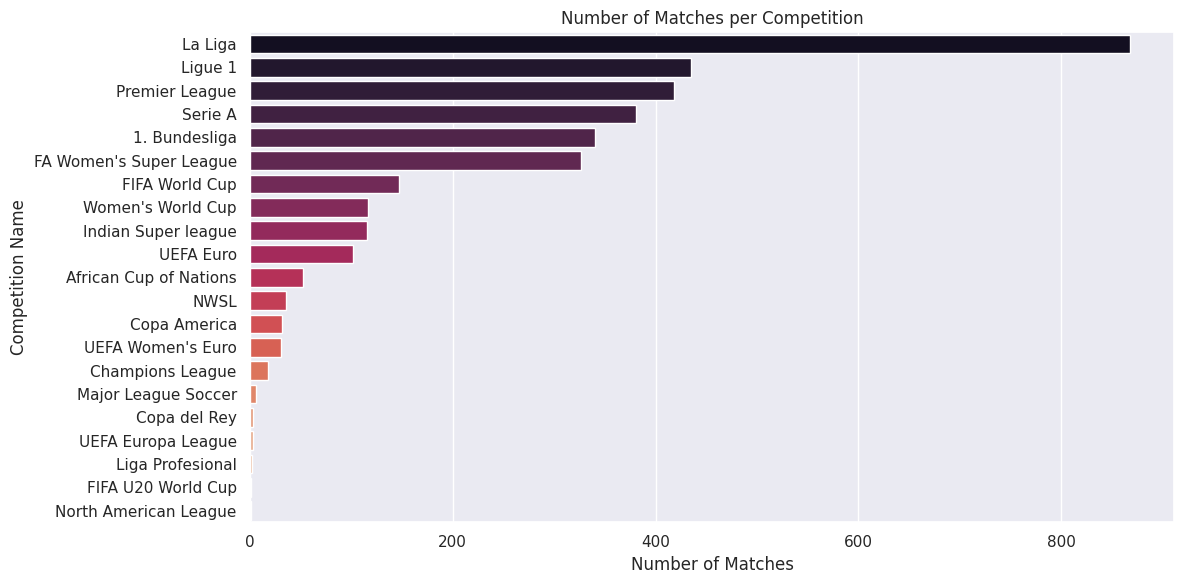

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=match_counts.values, y=match_counts.index, palette="rocket")

plt.title('Number of Matches per Competition')
plt.xlabel('Number of Matches')
plt.ylabel('Competition Name')
plt.tight_layout()
plt.show()


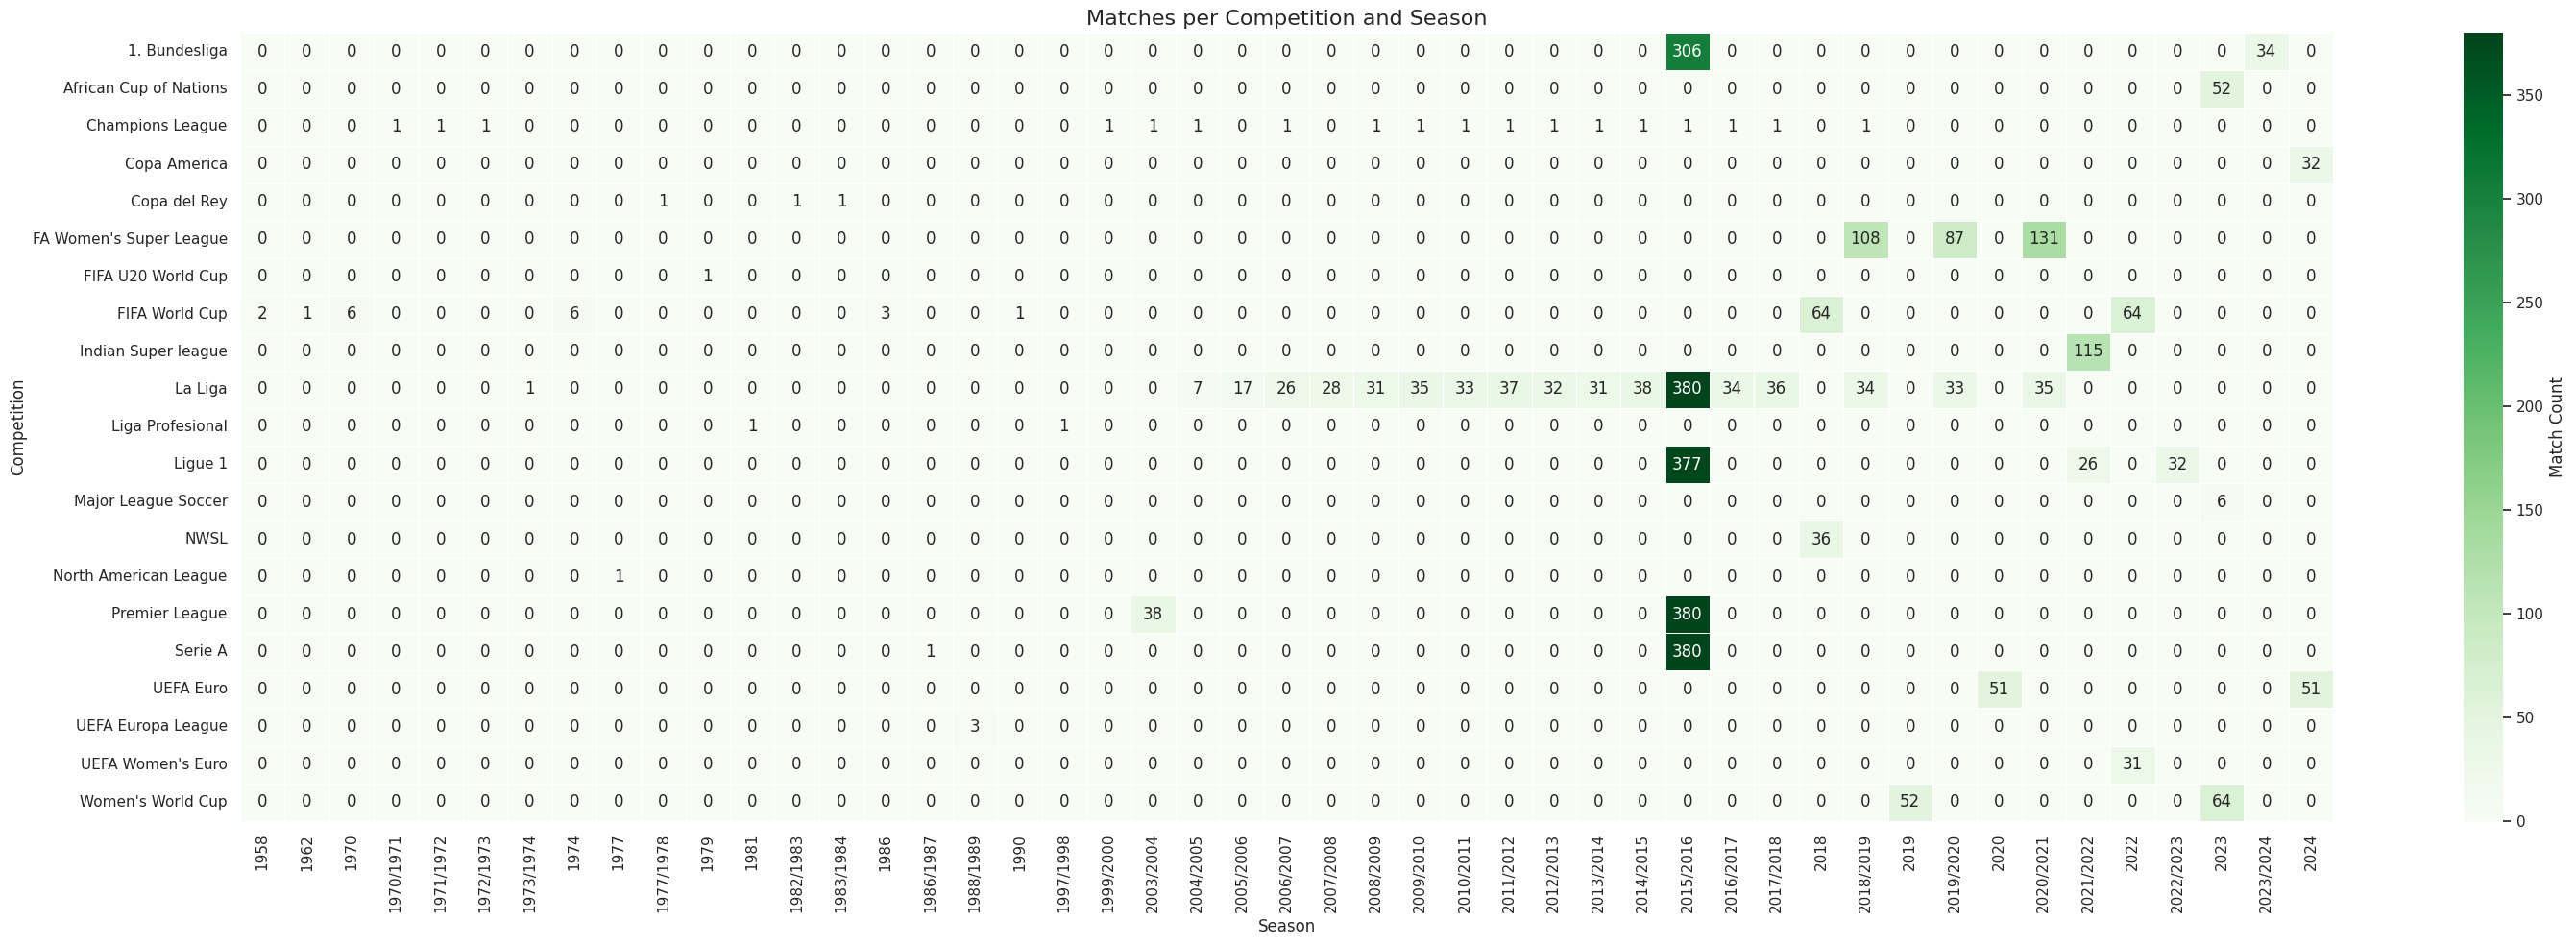

In [64]:
# Create a pivot table: rows = competition, columns = season, values = match count
pivot = all_matches.pivot_table(
    index='competition_name',
    columns='season_name',
    values='match_id',
    aggfunc='count',
    fill_value=0
)

# Remove total row and column before plotting
pivot_plot = pivot.drop(index='Total', errors='ignore') \
                              .drop(columns='Total', errors='ignore')


plt.figure(figsize=(30, 10))  # Increase width and height
sns.set(font_scale=1.0)       # Slightly bigger text, adjust if needed



# Plot heatmap without totals
ax = sns.heatmap(pivot_plot,
                 cmap = "Greens",
                 linewidths=0.5,
                 annot=True,
                 fmt='d',
                 cbar_kws={'label': 'Match Count'})

plt.title('Matches per Competition and Season', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Competition')
plt.tight_layout()
plt.show()


In [ ]:
df_event, df_related, df_freeze, df_tactics = parser.event(69301)
df_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 0 to 3288
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3289 non-null   object 
 1   index                           3289 non-null   int64  
 2   period                          3289 non-null   int64  
 3   timestamp                       3289 non-null   object 
 4   minute                          3289 non-null   int64  
 5   second                          3289 non-null   int64  
 6   possession                      3289 non-null   int64  
 7   duration                        2457 non-null   float64
 8   match_id                        3289 non-null   int64  
 9   type_id                         3289 non-null   int64  
 10  type_name                       3289 non-null   object 
 11  possession_team_id              3289 non-null   int64  
 12  possession_team_name            32

In [ ]:
all_matches.info()
all_matches.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3433 entries, 0 to 3432
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   match_id                         3433 non-null   int64         
 1   match_date                       3433 non-null   datetime64[ns]
 2   kick_off                         3428 non-null   datetime64[ns]
 3   home_score                       3433 non-null   int64         
 4   away_score                       3433 non-null   int64         
 5   match_status                     3433 non-null   object        
 6   match_status_360                 3433 non-null   object        
 7   last_updated                     3433 non-null   datetime64[ns]
 8   last_updated_360                 1797 non-null   datetime64[ns]
 9   match_week                       3433 non-null   int64         
 10  competition_id                   3433 non-null   int64      

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
0,3895302,2024-04-14,2024-04-14 17:30:00,5,0,available,available,2024-05-10 16:57:53.017895,2024-05-10 17:03:59.613154,29,...,1,Regular Season,377.0,BayArena,85.0,Germany,234.0,Harm Osmers,85.0,Germany
1,3895292,2024-04-06,2024-04-06 15:30:00,0,1,available,available,2024-05-12 21:04:50.061716,2024-05-12 21:08:37.897296,28,...,1,Regular Season,560.0,Stadion An der Alten Försterei,85.0,Germany,235.0,Benjamin Brand,85.0,Germany
2,3895333,2024-05-05,2024-05-05 18:30:00,1,5,available,available,2024-05-14 16:23:06.325967,2024-05-14 16:32:13.483516,32,...,1,Regular Season,116458.0,Deutsche Bank Park,85.0,Germany,237.0,Christian Dingert,85.0,Germany
3,3895340,2024-05-12,2024-05-12 20:30:00,0,5,available,available,2024-05-14 10:09:25.875345,2024-05-14 16:46:08.459843,33,...,1,Regular Season,550.0,Vonovia Ruhrstadion,85.0,Germany,235.0,Benjamin Brand,85.0,Germany
4,3895348,2024-05-18,2024-05-18 16:30:00,2,1,available,available,2024-05-20 10:11:27.857660,2024-05-20 10:33:09.140760,34,...,1,Regular Season,377.0,BayArena,85.0,Germany,837.0,Matthias Jöllenbeck,85.0,Germany
